In [1]:
#   自定义VOC格式数据集的读取
import torch
import torchvision
from torchvision.transforms import ToPILImage
from PIL import Image             #调用库
import os

show=ToPILImage()                         #Tensor转换为Image   利于后续可视化
# use PIL Image to read image
# def default_loader(path):
#     try:
#         img = Image.open(path)
#         # print(path)
#         return img
#     except:
#         print("Cannot read image: {}".format(path))
transformer=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])       
class customData(torch.utils.data.Dataset):
#     def __init__(self, img_path, txt_path, data_transforms=transform, loader=default_loader):
    def __init__(self, img_path, txt_path, data_transforms=transformer):
        self.img_names = []
        self.img_labels = []  #list
        fr = open(txt_path)
        for line in fr.readlines():  # 逐行读取
            line = line.strip()  # 滤除行首行尾空格
            for n in line[-6:]:  # 遍历连续的五个数字
                self.img_labels.append(int(n))  # 将五个数字都添加为标签

        files = os.listdir(img_path)
        files.sort(key=lambda x: int(x.split('.')[0]))
        for fn in files:
            self.img_names.append(os.path.join(img_path, fn))

        self.data_transforms = data_transforms
       

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, item):
        img_name = self.img_names[item]
        label = self.img_labels[item]
#       img = self.loader(img_name)
        #convert('L') 转换为灰度图
        img = Image.open(img_name).convert('L')


        if self.data_transforms is not None:
            try: 
                img = self.data_transforms(img)
            except:
                print("Cannot transform image: {}".format(img_name))
        return img, label



In [2]:
trainset=customData(img_path='C:/data/SSDD/VOC2007/JPEGImages',
                    txt_path='C:/data/SSDD/VOC2007/ImageSets/Main/train.txt'
                    )
testset=customData(img_path='C:\data\SSDD\VOC2007\JPEGImages',
                    txt_path='C:/data/SSDD/VOC2007/ImageSets/Main/test.txt'
                    )

In [3]:
trainloader=torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,      #洗牌 打乱
    num_workers=1)

testloader=torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,    #测试集不用打乱  
    num_workers=1)

In [4]:
(data,_)=trainset[3]

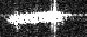

In [5]:
show(data)

In [6]:
data.shape

torch.Size([1, 37, 87])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
#定义卷积层
conv1=nn.Conv2d(1,6,5)
conv2=nn.Conv2d(6,16,5)
#定义最大池化层
maxpooling=nn.MaxPool2d(2,2)                 

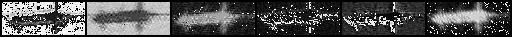

In [8]:
data.unsqueeze_(0)
#通过卷积1，输出6通道的feature maps
out1=conv1(data)
pic1=torchvision.utils.make_grid(out1.transpose(0,1))
show(pic1)

In [9]:
#最大池化
out2_1=maxpooling(out1)
pic2_1=torchvision.utils.make_grid(out2_1.transpose(0,1))
show(pic2_1)

In [10]:
#雙樹復數小波變換
import torch
from pytorch_wavelets import DTCWTForward, DTCWTInverse
xfm = DTCWTForward(J=2, biort='near_sym_b', qshift='qshift_b')
X = out1
Yl, Yh = xfm(X)
out2_2=Yl
print(Yl.shape)
print(Yh[0].shape)
# print(Yh[1].shape)
# print(Yh[2].shape)
ifm = DTCWTInverse(biort='near_sym_b', qshift='qshift_b')
Y = ifm((Yl, Yh))

torch.Size([1, 6, 18, 42])
torch.Size([1, 6, 6, 17, 42, 2])


In [11]:
pic2_2=torchvision.utils.make_grid(out2_2.transpose(0,1))
show(pic2_2)

In [12]:
#取第1张图片分析
print(out2_1[0,0,:,:].shape)
print(out2_2[0,0,:,:].shape)

torch.Size([16, 41])
torch.Size([18, 42])


(-0.5, 41.5, 17.5, -0.5)

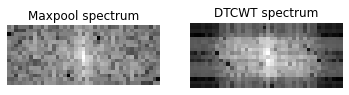

In [13]:
import matplotlib.pyplot as plt
import numpy as np
#图片频谱分析
f2_1= np.fft.fft2(out2_1[0,0,:,:].detach().numpy()) #转换为numpy再处理
#默认结果中心点位置是在左上角,
#调用fftshift()函数转移到中间位置
fshift_2_1 = np.fft.fftshift(f2_1)       
#fft结果是复数, 其绝对值结果是振幅
fimg2_1 = np.log(np.abs(fshift_2_1))

f_2_2 = np.fft.fft2(out2_2[0,0,:,:].detach().numpy())
#默认结果中心点位置是在左上角
#调用fftshift()函数转移到中间位置
fshift_2_2 = np.fft.fftshift(f_2_2)       
#fft结果是复数, 其绝对值结果是振幅
fimg2_2 = np.log(np.abs(fshift_2_2))
#展示结果
plt.subplot(121), plt.imshow(fimg2_1, 'gray'), plt.title('Maxpool spectrum')
plt.axis('off')
plt.subplot(122), plt.imshow(fimg2_2, 'gray'), plt.title('DTCWT spectrum')
plt.axis('off')